In [3]:
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy


INFO:root:Removed 1 of 320 phosphene locations.
INFO:root:Removed 3 of 320 phosphene locations.


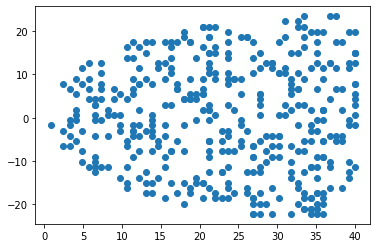

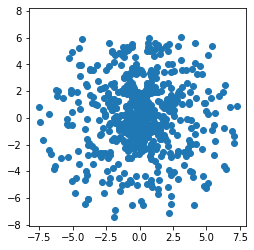

In [5]:
logging.basicConfig(level=logging.INFO)

# read parameters from yaml file
params = utils.load_params('../config/params.yaml')
params['thresholding']['use_threshold'] = False

# initialise phopshene locations, either using a cortex model or semi-probabilistically
coordinates_cortex = utils.load_coordinates_from_yaml('../config/grid_coords_dipole_valid.yaml', n_coordinates=400)
coordinates_cortex = Map(*coordinates_cortex)
coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(params['cortex_model'], coordinates_cortex)
r, phi = coordinates_visual_field.polar

# plot electrode locations
plt.scatter(*coordinates_cortex.cartesian)
plt.show()
# or:
# r, phi = init.init_probabilistically(params,n_phosphenes=1000)

# plot phosphene locations
plt.scatter(r*np.cos(phi),r*np.sin(phi))
plt.axis('square')
plt.show()

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

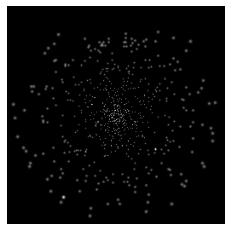

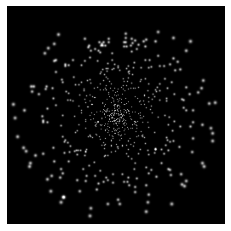

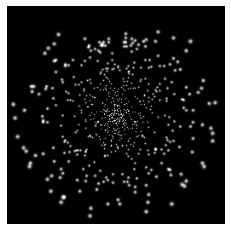

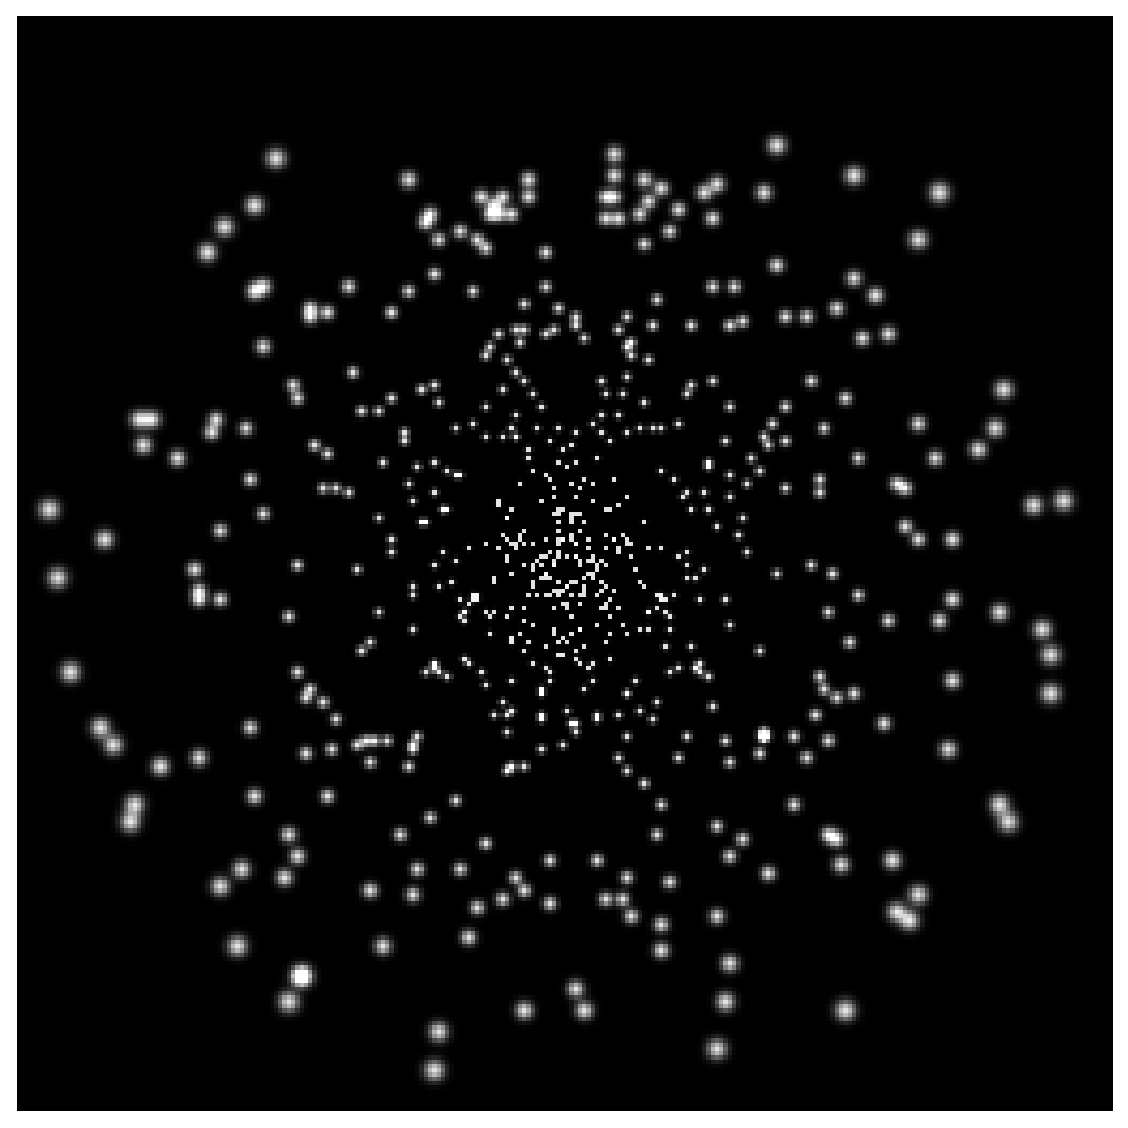

In [6]:
# plot phosphenes for different input strengths
stims = np.array([60.,80.,100.])*1e-6

img = None
for i,stim in enumerate(stims):

    simulator.reset()
    stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
    img = to_numpy(simulator(stim_pattern)).clip(max=1)

    plt.imshow(img,cmap='gray',origin='lower')
    plt.axis('off')
    plt.show()

# in real size (assuming 60cm distance to screen)
utils.display_real_size(params, img*255)

# plt.hist(simulator.brightness.numpy())
# plt.title('brightness histogram')
# plt.xlabel('brightness')
# plt.ylabel('count')
# plt.show()

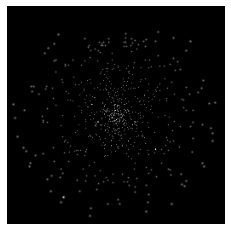

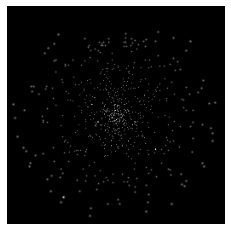

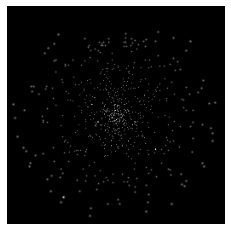

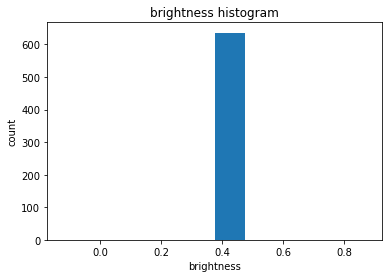

In [7]:
# plot phosphenes for different pulse widths
stim_amp = 30e-6
freq = 300
PWs = np.array([170.,400.,800.])*1e-6

for i,PW in enumerate(PWs):

    simulator.reset()
    stim = stim_amp*torch.ones(N_PHOSPHENES,device=device)
    f = freq*torch.ones(N_PHOSPHENES,device=device)
    pw = PW*torch.ones(N_PHOSPHENES,device=device)
    img = simulator(stim,pw,f).cpu().numpy().clip(max=1)

    plt.imshow(img,cmap='gray',origin='lower')
    plt.axis('off')
    plt.show()

# histogram of brightness
plt.hist(to_numpy(simulator.brightness.get()).ravel())
plt.title('brightness histogram')
plt.xlabel('brightness')
plt.ylabel('count')
plt.show()

## Example preprocessing

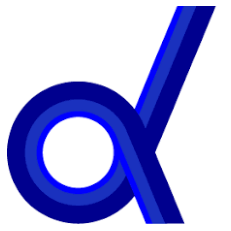

In [8]:
img = cv2.imread('../test/data/donders.png')

plt.axis('off')
plt.imshow(img)

In [9]:
# general preprocessing
frame = cv2.resize(img, RESOLUTION)
frame = 255 - cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.GaussianBlur(frame, (3,3), 0)

# some filters + sampling mechanism
img_sobel = sobel_processor(frame)
stim_sobel_rf = simulator.sample_stimulus(img_sobel)
img_canny = canny_processor(frame,threshold_low=200,threshold_high=220)
stim_canny_rf = simulator.sample_stimulus(img_canny)
img_gray = frame.clip(0,1)*255.
stim_gray_rf = simulator.sample_stimulus(img_gray)

(-0.5, 255.5, 255.5, -0.5)

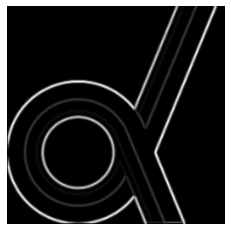

In [10]:
plt.imshow(img_sobel,cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

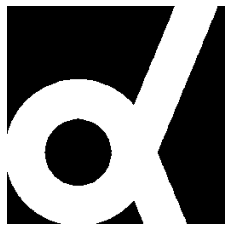

In [11]:
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

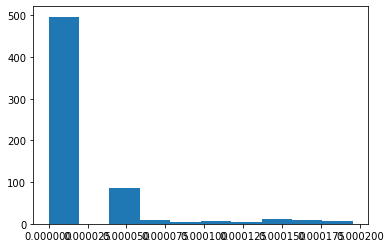

In [12]:
# sampled stimulation strengths
plt.hist(stim_sobel_rf.numpy())
plt.show()

0.016593466


(-0.5, 255.5, 255.5, -0.5)

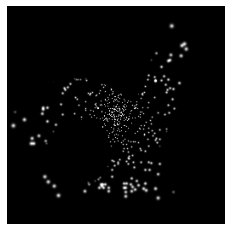

In [13]:
simulator.reset()
phs = to_numpy(simulator(stim_gray_rf))
print(phs.mean())
plt.imshow(phs,cmap='gray')
plt.axis('off')

## Process video

In [14]:
simulator.reset()
FRAMERATE = params['run']['fps']
#save activations for plotting. If saving the history for all phosphenes, only simulate for a few frames (uses a lot of memory and fries my laptop)
history = None
save_history = False
if save_history:
    history = {key: [] for key in simulator.get_state()}
    history['stimulation'] = []
    print(history)

prev = 0
cap = cv2.VideoCapture('clip.mp4')

max_n_frames = 6*FRAMERATE

if not cap.isOpened():
    print('Unable to read file :(')
    
fourcc = cv2.VideoWriter_fourcc(*'XVID') #codec
out = cv2.VideoWriter('clip_phosphenes.avi', fourcc, FRAMERATE, (512,256),False)
frame_nr = 0
while frame_nr<max_n_frames:
    ret, frame = cap.read()
    frame_nr+=1
    if ret:
        # to one channel, grayscale 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # get square if frame is not square
        if frame.shape[0] != frame.shape[1]:
            shortest_side = min(frame.shape)
            frame = frame[frame.shape[0]//2-shortest_side//2:frame.shape[0]//2+shortest_side//2,frame.shape[1]//2-shortest_side//2:frame.shape[1]//2+shortest_side//2]
            
        # preprocess: to resize, grayscale and blur
        frame = cv2.resize(frame, RESOLUTION)
        # frame = cv2.GaussianBlur(frame, (3,3), 0)

        # edge/contour detector
        # processed_img = canny_processor(frame,T_HIGH//2,T_HIGH)
        # processed_img = sobel_processor(frame)
        processed_img = frame
        stim_pattern = simulator.sample_stimulus(processed_img)
        # stim_pattern = sample_centers(processed_img, simulator.pMap)

        # Generate phosphenes 
        phs = simulator(stim_pattern).clamp(0,1)
        phs = to_numpy(phs)*255

        if save_history:
            state = simulator.get_state()
            for key in state:
                print(key)
                print(state[key])
                history[key].append(state[key])
                print(history[key])
            history['stimulation'].append(to_numpy(stim_pattern))

        # Concatenate results
        # cat = np.concatenate([frame, processed_img, phs], axis=1).astype('uint8')
        cat = np.concatenate([processed_img, phs], axis=1).astype('uint8')
        
        out.write(cat)

    else:
        break
    # the 'q' button is set as the quit button
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release() 

cv2.destroyAllWindows()

In [12]:
histo = history.copy()

print(len(history['sigma']))
#from list to 2D arrays 
for key in histo.keys():
    histo[key] = np.stack(histo[key], axis=0)


max_stimul = np.argmax(histo['stimulation'].sum(axis=0))
print(max_stimul)

AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
target_phos = max_stimul

plt.imshow(to_numpy(simulator.sampling_mask[target_phos,:,:]))

In [ ]:
print(histo['trace_fast'].shape)
time = np.arange(len(history['stimulation']))

fig,axs = plt.subplots(4,1, figsize=(10,15), sharex='true')
axs[0].plot(time,histo['stimulation'][:,target_phos])
axs[0].set_ylabel('stimulation ($\mu$A)')
axs[1].plot(time,histo['trace_fast'][:,target_phos], label='fast trace')
axs[1].plot(time,histo['trace_slow'][:,target_phos], label='slow trace')
axs[1].set_ylabel('trace value')
axs[1].legend()
axs[2].plot(time,histo['sigma'][:,target_phos])
axs[2].set_ylabel('sigma (pixels)')
axs[3].plot(time,histo['brightness'][:,target_phos])
axs[3].set_ylabel('brightness (0-1)')
axs[3].set_xlabel('Time (frames)')